In [87]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

from scipy.stats import linregress
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import warnings
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, message="The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.")

# %%
def load_data(ticker='SPY', start='2008-01-01', end=None):
    """
    Load historical data for a given ticker using yfinance.
    """
    if end is None:
        end = datetime.now().strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start, end=end)
    return df

def extract_monthly_data(seasonality_table, month):
    """
    Extract data for a specific month.
    """
    return seasonality_table.loc[month]

def visualize_monthly_data(monthly_data, month):
    """
    Visualize the extracted data for the selected month.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(monthly_data.index, monthly_data.values, color='dodgerblue')
    plt.xlabel('Year')
    plt.ylabel(f'Average {month} Return (%)')
    plt.title(f'Average {month} Returns Over the Years')
    plt.xticks(rotation=45)
    plt.show()

def perform_quantitative_analysis(monthly_data, month):
    """
    Perform quantitative analysis on the extracted monthly data.
    """
    mean_return = monthly_data.mean()
    std_return = monthly_data.std()
    highest_return_year = monthly_data.idxmax()
    highest_return_value = monthly_data.max()
    lowest_return_year = monthly_data.idxmin()
    lowest_return_value = monthly_data.min()

    print(f"Mean {month} Return: {mean_return:.2f}%")
    print(f"Standard Deviation of {month} Returns: {std_return:.2f}%")
    print(f"Highest {month} Return: {highest_return_value:.2f}% in {highest_return_year}")
    print(f"Lowest {month} Return: {lowest_return_value:.2f}% in {lowest_return_year}")

    # Determine Overall Trend
    years = monthly_data.index.astype(int)
    returns = monthly_data.values
    if len(set(returns)) > 1:  # Check for variance in data
        slope, intercept, r_value, p_value, std_err = linregress(years, returns)

        plt.figure(figsize=(10, 6))
        plt.bar(monthly_data.index, monthly_data.values, color='dodgerblue', label=f'{month} Return')
        plt.plot(monthly_data.index, intercept + slope*years, 'r', label=f'Trend Line (slope={slope:.2f})')
        plt.xlabel('Year')
        plt.ylabel(f'Average {month} Return (%)')
        plt.title(f'Average {month} Returns Over the Years with Trend Line')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()

        print(f"Trend Line Slope: {slope:.2f}% per year")
        print(f"R-squared: {r_value**2:.2f}")
    else:
        print(f"No variance in {month} data to compute trend line.")

def calculate_technical_indicators(df):
    """
    Calculate RSI, Bollinger Bands, and MACD for the given dataframe.
    """
    # Calculate RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    # Calculate Bollinger Bands
    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)

    # Calculate MACD
    df['12 EMA'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['26 EMA'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['12 EMA'] - df['26 EMA']
    df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    print("Technical Indicators:\n", df[['RSI', 'Upper Band', 'Lower Band', 'MACD', 'Signal Line']].head())
    return df

def plot_monthly_technical_indicators(df):
    """
    Plot RSI, Bollinger Bands, and MACD for the given dataframe.
    """
    plt.figure(figsize=(14, 10))

    # Plot Close Price and Bollinger Bands
    plt.subplot(4, 1, 1)
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['Upper Band'], label='Upper Bollinger Band', linestyle='--', color='r')
    plt.plot(df['Lower Band'], label='Lower Bollinger Band', linestyle='--', color='b')
    plt.fill_between(df.index, df['Upper Band'], df['Lower Band'], alpha=0.1)
    plt.title('Monthly Close Price and Bollinger Bands')
    plt.legend()

    # Plot RSI
    plt.subplot(4, 1, 2)
    plt.plot(df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', alpha=0.5, color='r')
    plt.axhline(30, linestyle='--', alpha=0.5, color='g')
    plt.title('Monthly Relative Strength Index (RSI)')
    plt.legend()

    # Plot MACD
    plt.subplot(4, 1, 3)
    plt.plot(df['MACD'], label='MACD', color='g')
    plt.plot(df['Signal Line'], label='Signal Line', color='orange')
    plt.fill_between(df.index, df['MACD'] - df['Signal Line'], 0, alpha=0.2, color='grey')
    plt.title('Monthly MACD and Signal Line')
    plt.legend()

    plt.tight_layout()
    plt.show()

def fetch_fed_data(series, start_date='2008-01-01'):
    """
    Fetch macroeconomic data from FRED.
    """
    return pdr.get_data_fred(series, start=start_date)

def merge_macro_data(financial_df, macro_df):
    """
    Merge financial data with macroeconomic data.
    """
    macro_df = macro_df.resample('M').ffill()  # Ensure macro data is also monthly
    merged_df = financial_df.merge(macro_df, left_index=True, right_index=True, how='inner')
    print("Merged Data:\n", merged_df.head())
    return merged_df

def plot_with_macro_data(merged_df):
    """
    Plot financial indicators with macroeconomic data.
    """
    fig, axs = plt.subplots(4, 1, figsize=(14, 12))

    # Plot Close Price and Bollinger Bands
    axs[0].plot(merged_df['Close'], label='Close Price')
    axs[0].plot(merged_df['Upper Band'], label='Upper Bollinger Band', linestyle='--', color='r')
    axs[0].plot(merged_df['Lower Band'], label='Lower Bollinger Band', linestyle='--', color='b')
    axs[0].fill_between(merged_df.index, merged_df['Upper Band'], merged_df['Lower Band'], alpha=0.1)
    axs[0].set_title('Monthly Close Price and Bollinger Bands')
    axs[0].legend()

    # Plot RSI
    axs[1].plot(merged_df['RSI'], label='RSI', color='purple')
    axs[1].axhline(70, linestyle='--', alpha=0.5, color='r')
    axs[1].axhline(30, linestyle='--', alpha=0.5, color='g')
    axs[1].set_title('Monthly Relative Strength Index (RSI)')
    axs[1].legend()

    # Plot MACD
    axs[2].plot(merged_df['MACD'], label='MACD', color='g')
    axs[2].plot(merged_df['Signal Line'], label='Signal Line', color='orange')
    axs[2].fill_between(merged_df.index, merged_df['MACD'] - merged_df['Signal Line'], 0, alpha=0.2, color='grey')
    axs[2].set_title('Monthly MACD and Signal Line')
    axs[2].legend()

    # Plot Fed Funds Rate
    axs[3].plot(merged_df['FEDFUNDS'], label='Federal Funds Rate', color='blue')
    axs[3].set_title('Federal Funds Rate')
    axs[3].legend()

    plt.tight_layout()
    plt.show()

# Define the half-Kelly criterion function
def half_kelly_criterion(mean_return, std_return):
    win_prob = (mean_return / std_return) ** 2 / ((mean_return / std_return) ** 2 + 1)
    loss_prob = 1 - win_prob
    odds = mean_return / std_return
    kelly_fraction = (win_prob - loss_prob) / odds
    half_kelly_fraction = kelly_fraction / 2
    return half_kelly_fraction

# Define portfolio return and variance calculations
def calculate_portfolio_return(weights, returns):
    return np.dot(weights, returns)

def calculate_portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Objective function to maximize portfolio return
def objective_function(weights):
    portfolio_return = calculate_portfolio_return(weights, returns)
    portfolio_variance = calculate_portfolio_variance(weights, cov_matrix)
    portfolio_std_dev = np.sqrt(portfolio_variance)
    return -portfolio_return  # Negative for minimization

def apply_kelly_method(mean_return, std_dev, win_prob):
    """Calculate the Kelly criterion for position sizing."""
    b = mean_return / std_dev  # Assuming b is the edge ratio
    kelly_fraction = win_prob - ((1 - win_prob) / b)
    return kelly_fraction

def machine_learning_analysis(df):
    """Perform machine learning analysis using RandomForest and return the model and accuracy."""
    df['Target'] = (df['Return'] > 0).astype(int)  # Binary classification: 1 if return is positive, 0 otherwise
    features = ['Adj Close', 'Return']  # Example features; you can add more technical indicators
    X = df[features].shift(1)  # Shift features to avoid look-ahead bias
    y = df['Target'].shift(1)
    # Drop rows with NaN values to ensure consistent lengths
    X, y = X.dropna(), y.dropna()
    X, y = X.align(y, join='inner', axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.2f}")
    return model, accuracy

def create_summary_csv(tickers, start_date, end_date, filename='summary.csv'):
    """Create a CSV file with mean, std, count, positive_prob, and Kelly size for all assets."""
    summary_data = []
    for ticker in tickers:
        df = load_price_data(ticker, start=start_date, end=end_date)
        if isinstance(df, pd.Series):
            df = df.to_frame(name='Adj Close')
        if 'Adj Close' not in df.columns:
            print(f"Column 'Adj Close' not found in the data for {ticker}. Available columns: {df.columns}")
            continue
        df = calculate_returns(df)
        seasonality_table = create_seasonality_table(df)
        for month, stats in seasonality_table.iterrows():
            mean_return = stats['mean']
            std_dev = stats['std']
            count = stats['count']
            positive_prob = stats['positive_prob']
            kelly_size = apply_kelly_method(mean_return, std_dev, positive_prob)
            summary_data.append({
                'Ticker': ticker,
                'Month': month,
                'Mean Return': mean_return,
                'Standard Deviation': std_dev,
                'Count': count,
                'Positive Probability': positive_prob,
                'Kelly Size': kelly_size
            })
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(filename, index=False)
    print(f"Summary CSV created: {filename}")

def analyze_ticker(ticker, start_date, end_date):
    df = load_price_data(ticker, start=start_date, end=end_date)
    if isinstance(df, pd.Series):
        df = df.to_frame(name='Adj Close')
    if 'Adj Close' not in df.columns:
        print(f"Column 'Adj Close' not found in the data for {ticker}. Available columns: {df.columns}")
        return
    df = calculate_returns(df)
    seasonality_table = create_seasonality_table(df)
    visualize_seasonality_table(seasonality_table, f'Seasonality of {ticker} Returns')
    display_all_monthly_statistics_with_kelly(df)
    # Machine Learning Analysis
    model, accuracy = machine_learning_analysis(df)

def seasonality_analysis(df):
    """Perform seasonality analysis."""
    return df.groupby(df.index.month)['Monthly Return'].agg(['mean', 'std', 'count', 'positive_prob'])

def plot_technical_indicators(df):
    """
    Plot RSI, Bollinger Bands, and MACD for the given dataframe.
    """
    plt.figure(figsize=(14, 10))

    # Plot Close Price and Bollinger Bands
    plt.subplot(3, 1, 1)
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['Upper Band'], label='Upper Bollinger Band', linestyle='--', color='r')
    plt.plot(df['Lower Band'], label='Lower Bollinger Band', linestyle='--', color='b')
    plt.fill_between(df.index, df['Upper Band'], df['Lower Band'], alpha=0.1)
    plt.title('Close Price and Bollinger Bands')
    plt.legend()

    # Plot RSI
    plt.subplot(3, 1, 2)
    plt.plot(df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', alpha=0.5, color='r')
    plt.axhline(30, linestyle='--', alpha=0.5, color='g')
    plt.title('Relative Strength Index (RSI)')
    plt.legend()

    # Plot MACD
    plt.subplot(3, 1, 3)
    plt.plot(df['MACD'], label='MACD', color='g')
    plt.plot(df['Signal Line'], label='Signal Line', color='orange')
    plt.fill_between(df.index, df['MACD'] - df['Signal Line'], 0, alpha=0.2, color='grey')
    plt.title('MACD and Signal Line')
    plt.legend()

    plt.tight_layout()

def calculate_returns(df, period='ME'):
    """
    Calculate percentage returns based on the specified period.
    """
    df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
    df['Volume'] = df['Volume'].resample(period).sum()  # Sum volume for each period
    return df

def create_seasonality_table(df, column='Return'):
    """
    Create a pivot table for seasonality analysis.
    """
    seasonality_table = df.pivot_table(values=column, index=df.index.year, columns=df.index.month, aggfunc=np.mean)
    # Ensure all months are represented
    seasonality_table = seasonality_table.reindex(columns=range(1, 13))
    seasonality_table.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    seasonality_table = seasonality_table.transpose()
    return seasonality_table

def visualize_seasonality_table(seasonality_table, ticker):
    """
    Visualize the seasonality table using a heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(seasonality_table, annot=True, fmt=".2f", cmap='RdYlGn', center=0)
    plt.title(f'Seasonality of {ticker} Returns')
    plt.show()

def display_all_monthly_statistics(seasonality_table, seasonality_volume_table, ticker):
    """
    Display the statistics for each month in the seasonality table.
    """
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for month in months:
        monthly_data = seasonality_table.loc[month]
        monthly_volume = seasonality_volume_table.loc[month]
        mean_return = monthly_data.mean()
        std_return = monthly_data.std()
        highest_return_year = monthly_data.idxmax()
        highest_return_value = monthly_data.max()
        lowest_return_year = monthly_data.idxmin()
        lowest_return_value = monthly_data.min()
        mean_volume = monthly_volume.mean()
        highest_volume_year = monthly_volume.idxmax()
        highest_volume_value = monthly_volume.max()
        lowest_volume_year = monthly_volume.idxmin()
        lowest_volume_value = monthly_volume.min()

        print(f"{ticker} - {month} Statistics")
        print(f"Mean {month} Return: {mean_return:.2f}%")
        print(f"Standard Deviation of {month} Returns: {std_return:.2f}%")
        print(f"Highest {month} Return: {highest_return_value:.2f}% in {highest_return_year}")
        print(f"Lowest {month} Return: {lowest_return_value:.2f}% in {lowest_return_year}")
        print(f"Mean {month} Volume: {mean_volume:.2f}")
        print(f"Highest {month} Volume: {highest_volume_value:.2f} in {highest_volume_year}")
        print(f"Lowest {month} Volume: {lowest_volume_value:.2f} in {lowest_volume_year}")
        print()


In [49]:
# from data_collection.data_processing import load_data

# from data_processing import load_data
# from data_seasonality import calculate_returns, create_seasonality_table, visualize_seasonality_table
# from data_visualization import calculate_technical_indicators, plot_monthly_technical_indicators


[*********************100%%**********************]  1 of 1 completed

Processing data for NVDA...



C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\2986058457.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\2986058457.py:328: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Volume'] = df['Volume'].resample(period).sum()  # Sum volume for each period
C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\2986058457.py:335: FutureWarning: The provided callable <function mean at 0x000001DD6D832FC0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  seasonality_table = df.pivot_table(values=column, index=df.index.year, columns=df.index.month, aggfunc=np.mean)
C:\Users\Administrator\AppData\Local\Temp\ipykerne

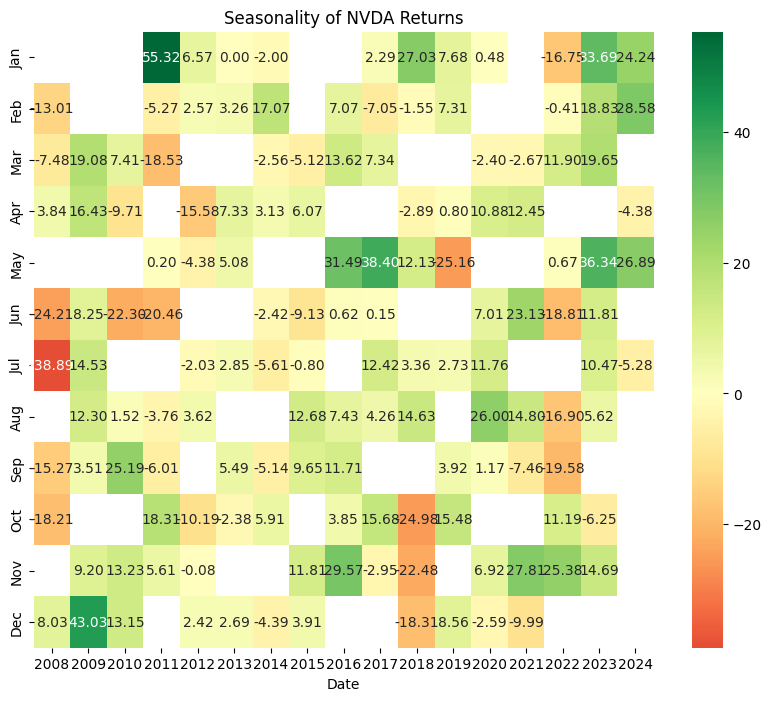

TypeError: display_all_monthly_statistics() takes 2 positional arguments but 3 were given

In [50]:


# Main execution for multiple tickers
# tickers = ['SPY', 'QQQ', 'DOW', 'SPYD', 'O', 'AGNC', 'TQQQ', 'SQQQ', 'SPXS', 'NVDL', 'TSLL', 'MSFT', 'BITO']
tickers = [ 'NVDA', 'TSLA', 'MSFT', 'BTC-USD']
for ticker in tickers:
    print(f"Processing data for {ticker}...")
    df = load_data(ticker)
    df = calculate_returns(df, period='M')
    seasonality_table = create_seasonality_table(df, column='Return')
    seasonality_volume_table = create_seasonality_table(df, column='Volume')
    visualize_seasonality_table(seasonality_table, ticker)
    display_all_monthly_statistics(seasonality_table, seasonality_volume_table, ticker)


[*********************100%%**********************]  1 of 1 completed
C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\3102572131.py:128: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').ffill()


Resampled Data:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2008-01-31  133.399994  138.539993  133.199997  137.369995  100.161163   
2008-02-29  135.600006  135.679993  132.779999  133.820007   97.572823   
2008-03-31  131.289993  132.729996  131.089996  131.970001   96.700249   
2008-04-30  139.289993  140.589996  138.259995  138.259995  101.309212   
2008-05-31  140.470001  140.740005  139.940002  140.350006  102.840630   

               Volume  
Date                   
2008-01-31  343680800  
2008-02-29  252715200  
2008-03-31  166692100  
2008-04-30  208395900  
2008-05-31  117362000  
Technical Indicators:
             RSI  Upper Band  Lower Band      MACD  Signal Line
Date                                                          
2008-01-31  NaN         NaN         NaN  0.000000     0.000000
2008-02-29  NaN         NaN         NaN -0.283190    -0.056638
2008-03-31  NaN      

C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\2986058457.py:154: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  macro_df = macro_df.resample('M').ffill()  # Ensure macro data is also monthly


Merged Data:
                   Open        High         Low       Close   Adj Close  \
2008-01-31  133.399994  138.539993  133.199997  137.369995  100.161163   
2008-02-29  135.600006  135.679993  132.779999  133.820007   97.572823   
2008-03-31  131.289993  132.729996  131.089996  131.970001   96.700249   
2008-04-30  139.289993  140.589996  138.259995  138.259995  101.309212   
2008-05-31  140.470001  140.740005  139.940002  140.350006  102.840630   

               Volume  RSI  20 Day MA  20 Day STD  Upper Band  Lower Band  \
2008-01-31  343680800  NaN        NaN         NaN         NaN         NaN   
2008-02-29  252715200  NaN        NaN         NaN         NaN         NaN   
2008-03-31  166692100  NaN        NaN         NaN         NaN         NaN   
2008-04-30  208395900  NaN        NaN         NaN         NaN         NaN   
2008-05-31  117362000  NaN        NaN         NaN         NaN         NaN   

                12 EMA      26 EMA      MACD  Signal Line  FEDFUNDS  
2008-01-

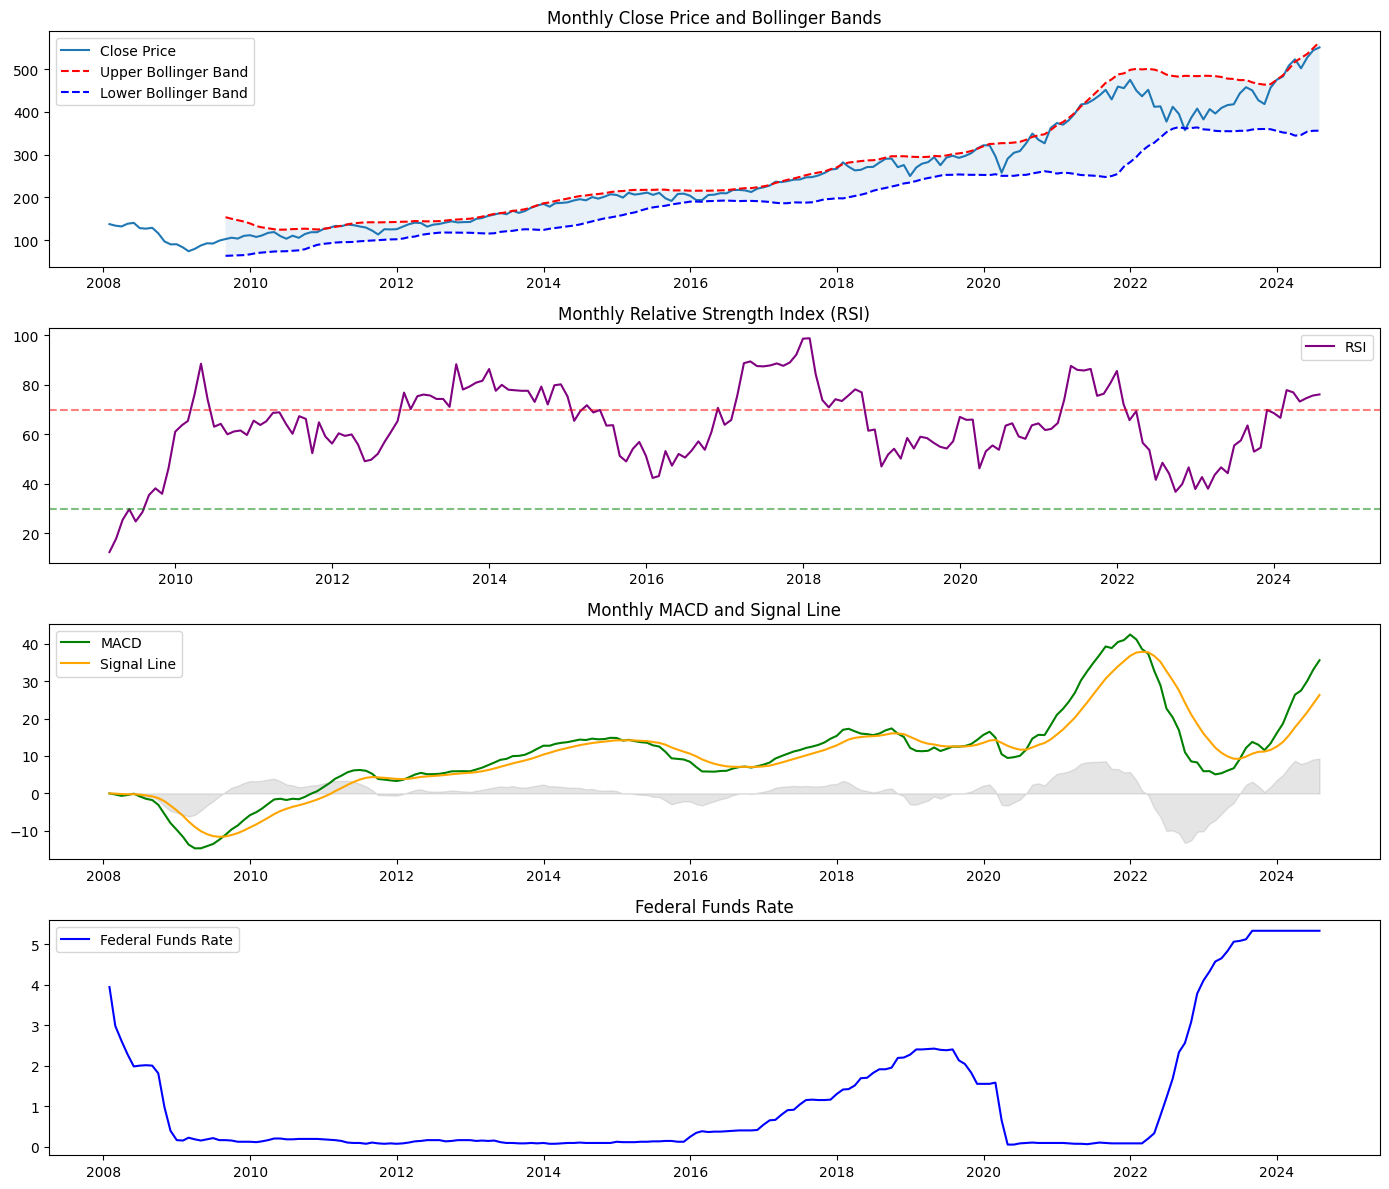

In [58]:


def main():
    # Load SPY data
    ticker = 'SPY'
    start_date = '2008-01-01'
    df = load_data(ticker, start=start_date)
    
    # Resample to monthly frequency
    df_monthly = resample_monthly(df)
    
    # Calculate technical indicators
    df_monthly = calculate_technical_indicators(df_monthly)
    
    # Fetch Fed data
    fed_funds = fetch_fed_data('FEDFUNDS', start_date=start_date)
    
    # Merge financial data with macroeconomic data
    merged_df = merge_macro_data(df_monthly, fed_funds)
    
    # Plot the combined data
    plot_with_macro_data(merged_df)

if __name__ == "__main__":
    main()


# Hedge Data

In [ ]:


# Data for SQQQ and SPXS
data = {
    'SQQQ': {'mean_return': -10.17, 'std_return': 15.41},
    'SPXS': {'mean_return': -6.49, 'std_return': 11.62}
}

# Calculate half-Kelly fractions
for ticker in data:
    mean_return = data[ticker]['mean_return']
    std_return = data[ticker]['std_return']
    half_kelly_fraction = half_kelly_criterion(mean_return, std_return)
    data[ticker]['half_kelly_fraction'] = half_kelly_fraction
    print(f"{ticker} - Half Kelly Fraction: {half_kelly_fraction:.4f}")

# Define portfolio return and variance calculations
# def calculate_portfolio_return(weights, returns):
#     return np.dot(weights, returns)

# def calculate_portfolio_variance(weights, cov_matrix):
#     return np.dot(weights.T, np.dot(cov_matrix, weights))

# Initial returns and standard deviations for SQQQ and SPXS
returns = np.array([data['SQQQ']['mean_return'], data['SPXS']['mean_return']])
std_devs = np.array([data['SQQQ']['std_return'], data['SPXS']['std_return']])
cov_matrix = np.diag(std_devs ** 2)

# # Objective function to maximize portfolio return
# def objective_function(weights):
#     portfolio_return = calculate_portfolio_return(weights, returns)
#     portfolio_variance = calculate_portfolio_variance(weights, cov_matrix)
#     portfolio_std_dev = np.sqrt(portfolio_variance)
#     return -portfolio_return  # Negative for minimization

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# Bounds: weights must be between 0 and 1
bounds = ((0, 1), (0, 1))

# Initial guess: equal weights
initial_guess = np.array([0.5, 0.5])

# Optimize the portfolio
result = minimize(objective_function, initial_guess, bounds=bounds, constraints=constraints)
optimal_weights = result.x

# Calculate optimal portfolio return and standard deviation
optimal_portfolio_return = calculate_portfolio_return(optimal_weights, returns)
optimal_portfolio_variance = calculate_portfolio_variance(optimal_weights, cov_matrix)
optimal_portfolio_std_dev = np.sqrt(optimal_portfolio_variance)

print(f"Optimal Weights: SQQQ: {optimal_weights[0]:.4f}, SPXS: {optimal_weights[1]:.4f}")
print(f"Optimal Portfolio Return: {optimal_portfolio_return:.2f}%")
print(f"Optimal Portfolio Standard Deviation: {optimal_portfolio_std_dev:.2f}%")

# Check if the optimized portfolio achieves the desired return
if optimal_portfolio_return > 1:
    print("The optimized portfolio achieves an average monthly return greater than 1%.")
else:
    print("The optimized portfolio does not achieve an average monthly return greater than 1%. Consider adding other assets or leveraging.")


In [ ]:
# Main execution for multiple tickers
tickers = ['SQQQ', 'SPXS']
for ticker in tickers:
    print(f"Processing data for {ticker}...")
    df = load_data(ticker)
    df = calculate_returns(df, period='M')
    seasonality_table = create_seasonality_table(df, column='Return')
    seasonality_volume_table = create_seasonality_table(df, column='Volume')
    visualize_seasonality_table(seasonality_table, ticker)
    display_all_monthly_statistics(seasonality_table, seasonality_volume_table, ticker)


In [ ]:
# import pandas as pd
# import numpy as np
# import yfinance as yf
# from datetime import datetime
# import matplotlib.pyplot as plt

# # Download historical data for SQQQ and SPXS
# def load_data(ticker, start='2008-01-01', end=None):
#     if end is None:
#         end = datetime.now().strftime('%Y-%m-%d')
#     df = yf.download(ticker, start=start, end=end)
#     return df

# # Calculate returns and fractional sizing
# def calculate_returns(df, period='M'):
#     df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
#     df['Volume'] = df['Volume'].resample(period).sum()
#     return df

# def half_kelly_criterion(mean_return, std_return):
#     win_prob = (mean_return / std_return) ** 2 / ((mean_return / std_return) ** 2 + 1)
#     loss_prob = 1 - win_prob
#     odds = mean_return / std_return
#     kelly_fraction = (win_prob - loss_prob) / odds
#     half_kelly_fraction = kelly_fraction / 2
#     return half_kelly_fraction

# Load and process data
tickers = ['SQQQ', 'SPXS']
data = {}
for ticker in tickers:
    df = load_data(ticker)
    df = calculate_returns(df, period='M')
    mean_return = df['Return'].mean()
    std_return = df['Return'].std()
    half_kelly_fraction = half_kelly_criterion(mean_return, std_return)
    data[ticker] = {
        'df': df,
        'mean_return': mean_return,
        'std_return': std_return,
        'half_kelly_fraction': half_kelly_fraction
    }

# Define initial capital and constraints
initial_capital = 5000
max_bet_fraction = 0.01
special_months = ['Jun', 'Sep']
stop_loss_threshold = -0.5
holding_period = 30

# Function to apply strategy
def apply_strategy(data, capital, max_bet_fraction, special_months, stop_loss_threshold, holding_period):
    portfolio_value = capital
    for ticker in data:
        df = data[ticker]['df']
        half_kelly_fraction = data[ticker]['half_kelly_fraction']
        monthly_returns = df['Return']
        for month, return_ in monthly_returns.items():
            if pd.isna(return_):
                continue
            month_name = month.strftime('%b')
            bet_fraction = half_kelly_fraction
            if month_name in special_months:
                bet_fraction = max_bet_fraction * 2
            bet_amount = portfolio_value * min(bet_fraction, max_bet_fraction)
            if return_ <= stop_loss_threshold:
                bet_amount = 0
            portfolio_value += bet_amount * (return_ / 100)
            if (month - monthly_returns.index[0]).days >= holding_period:
                portfolio_value = max(portfolio_value - bet_amount, 0)
    return portfolio_value

# Apply strategy and calculate final portfolio value
final_portfolio_value = apply_strategy(data, initial_capital, max_bet_fraction, special_months, stop_loss_threshold, holding_period)
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")

# Plot the results for visualization
def plot_portfolio_growth(data, initial_capital, max_bet_fraction, special_months, stop_loss_threshold, holding_period):
    portfolio_values = []
    portfolio_value = initial_capital
    dates = []
    for ticker in data:
        df = data[ticker]['df']
        half_kelly_fraction = data[ticker]['half_kelly_fraction']
        monthly_returns = df['Return']
        for month, return_ in monthly_returns.items():
            if pd.isna(return_):
                continue
            dates.append(month)
            month_name = month.strftime('%b')
            bet_fraction = half_kelly_fraction
            if month_name in special_months:
                bet_fraction = max_bet_fraction * 2
            bet_amount = portfolio_value * min(bet_fraction, max_bet_fraction)
            if return_ <= stop_loss_threshold:
                bet_amount = 0
            portfolio_value += bet_amount * (return_ / 100)
            portfolio_values.append(portfolio_value)
            if (month - monthly_returns.index[0]).days >= holding_period:
                portfolio_value = max(portfolio_value - bet_amount, 0)
    plt.plot(dates, portfolio_values)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.title('Portfolio Growth Over Time')
    plt.show()

# Plot the portfolio growth
plot_portfolio_growth(data, initial_capital, max_bet_fraction, special_months, stop_loss_threshold, holding_period)


In [60]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import yfinance as yf
# from datetime import datetime

def calculate_technical_indicators(df):
    # Calculate ATR
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['ATR'] = true_range.rolling(window=14).mean()
    
    # Calculate RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))
    
    # Calculate Bollinger Bands
    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    
    # Calculate Ichimoku Cloud
    high_9 = df['High'].rolling(window=9).max()
    low_9 = df['Low'].rolling(window=9).min()
    df['tenkan_sen'] = (high_9 + low_9) / 2

    high_26 = df['High'].rolling(window=26).max()
    low_26 = df['Low'].rolling(window=26).min()
    df['kijun_sen'] = (high_26 + low_26) / 2

    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)
    high_52 = df['High'].rolling(window=52).max()
    low_52 = df['Low'].rolling(window=52).min()
    df['senkou_span_b'] = ((high_52 + low_52) / 2).shift(26)

    df['chikou_span'] = df['Close'].shift(-26)
    
    return df

def display_all_monthly_statistics(df, ticker):
    df = calculate_technical_indicators(df)
    
    # Resample data to monthly
    df_monthly = df.resample('M').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',
        'ATR': 'mean',
        'RSI': 'mean',
        '20 Day MA': 'mean',
        'Upper Band': 'mean',
        'Lower Band': 'mean',
        'tenkan_sen': 'mean',
        'kijun_sen': 'mean',
        'senkou_span_a': 'mean',
        'senkou_span_b': 'mean',
        'chikou_span': 'mean'
    })
    
    df_monthly['Return'] = df_monthly['Close'].pct_change() * 100
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for month in range(1, 13):
        monthly_data = df_monthly[df_monthly.index.month == month]
        if monthly_data.empty:
            continue
        mean_return = monthly_data['Return'].mean()
        std_return = monthly_data['Return'].std()
        highest_return_year = monthly_data['Return'].idxmax().year
        highest_return_value = monthly_data['Return'].max()
        lowest_return_year = monthly_data['Return'].idxmin().year
        lowest_return_value = monthly_data['Return'].min()
        mean_volume = monthly_data['Volume'].mean()
        highest_volume_year = monthly_data['Volume'].idxmax().year
        highest_volume_value = monthly_data['Volume'].max()
        lowest_volume_year = monthly_data['Volume'].idxmin().year
        lowest_volume_value = monthly_data['Volume'].min()

        print(f"{ticker} - {months[month-1]} Statistics")
        print(f"Mean {months[month-1]} Return: {mean_return:.2f}%")
        print(f"Standard Deviation of {months[month-1]} Returns: {std_return:.2f}%")
        print(f"Highest {months[month-1]} Return: {highest_return_value:.2f}% in {highest_return_year}")
        print(f"Lowest {months[month-1]} Return: {lowest_return_value:.2f}% in {lowest_return_year}")
        print(f"Mean {months[month-1]} Volume: {mean_volume:.2f}")
        print(f"Highest {months[month-1]} Volume: {highest_volume_value:.2f} in {highest_volume_year}")
        print(f"Lowest {months[month-1]} Volume: {lowest_volume_value:.2f} in {lowest_volume_year}")
        print(f"Mean {months[month-1]} ATR: {monthly_data['ATR'].mean():.2f}")
        print(f"Mean {months[month-1]} RSI: {monthly_data['RSI'].mean():.2f}")
        print(f"Mean {months[month-1]} 20 Day MA: {monthly_data['20 Day MA'].mean():.2f}")
        print(f"Mean {months[month-1]} Upper Band: {monthly_data['Upper Band'].mean():.2f}")
        print(f"Mean {months[month-1]} Lower Band: {monthly_data['Lower Band'].mean():.2f}")
        print(f"Mean {months[month-1]} Tenkan-sen: {monthly_data['tenkan_sen'].mean():.2f}")
        print(f"Mean {months[month-1]} Kijun-sen: {monthly_data['kijun_sen'].mean():.2f}")
        print(f"Mean {months[month-1]} Senkou Span A: {monthly_data['senkou_span_a'].mean():.2f}")
        print(f"Mean {months[month-1]} Senkou Span B: {monthly_data['senkou_span_b'].mean():.2f}")
        print(f"Mean {months[month-1]} Chikou Span: {monthly_data['chikou_span'].mean():.2f}")

        # Add checks for conditions
        close_greater_than_rsi = (monthly_data['Close'] > monthly_data['RSI']).sum()
        close_greater_than_upper_band = (monthly_data['Close'] > monthly_data['Upper Band']).sum()
        high_greater_than_atr = (monthly_data['High'] > monthly_data['ATR']).sum()

        print(f"Number of days Close > RSI in {months[month-1]}: {close_greater_than_rsi}")
        print(f"Number of days Close > Upper Bollinger Band in {months[month-1]}: {close_greater_than_upper_band}")
        print(f"Number of days High > ATR in {months[month-1]}: {high_greater_than_atr}")
        print()


df = load_data('SPY')
display_all_monthly_statistics(df, 'SPY')


[*********************100%%**********************]  1 of 1 completed

SPY - Jan Statistics
Mean Jan Return: 0.36%
Standard Deviation of Jan Returns: 4.81%
Highest Jan Return: 8.01% in 2019
Lowest Jan Return: -8.21% in 2009
Mean Jan Volume: 2853895582.35
Highest Jan Volume: 6872039400.00 in 2009
Lowest Jan Volume: 1392003800.00 in 2020
Mean Jan ATR: 3.06
Mean Jan RSI: 56.76
Mean Jan 20 Day MA: 241.22
Mean Jan Upper Band: 249.02
Mean Jan Lower Band: 233.42
Mean Jan Tenkan-sen: 241.19
Mean Jan Kijun-sen: 246.59
Mean Jan Senkou Span A: 243.44
Mean Jan Senkou Span B: 238.36
Mean Jan Chikou Span: 244.76
Number of days Close > RSI in Jan: 17
Number of days Close > Upper Bollinger Band in Jan: 4
Number of days High > ATR in Jan: 17

SPY - Feb Statistics
Mean Feb Return: 0.42%
Standard Deviation of Feb Returns: 4.78%
Highest Feb Return: 5.62% in 2015
Lowest Feb Return: -10.74% in 2009
Mean Feb Volume: 2691990176.47
Highest Feb Volume: 7275092500.00 in 2009
Lowest Feb Volume: 1307806200.00 in 2021
Mean Feb ATR: 3.42
Mean Feb RSI: 57.83
Mean Feb 20 Day MA: 243.87
M


C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\3348174093.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').agg({


## Monthly Analysis and Recommendations

### January
- **Mean Return**: 0.36%
- **Standard Deviation**: 4.81%
- **Highest Return**: 8.01%
- **Lowest Return**: -8.21%
- **Recommendation**: Hedge or hold. The mean return is low and the standard deviation is relatively high, indicating potential volatility without substantial upside.

### February
- **Mean Return**: 0.42%
- **Standard Deviation**: 4.78%
- **Highest Return**: 5.62%
- **Lowest Return**: -10.74%
- **Recommendation**: Hedge. Similar to January, February's mean return is slightly positive but with significant risk.

### March
- **Mean Return**: 1.23%
- **Standard Deviation**: 4.72%
- **Highest Return**: 7.56%
- **Lowest Return**: -13.00%
- **Recommendation**: Buy or hedge. March has a higher mean return, making it more attractive for buying, though the risk is still notable.

### April
- **Mean Return**: 2.05%
- **Standard Deviation**: 4.81%
- **Highest Return**: 12.70%
- **Lowest Return**: -8.78%
- **Recommendation**: Buy. April has a solid mean return and potential for high upside, making it a good month to buy.

### May
- **Mean Return**: 0.50%
- **Standard Deviation**: 3.92%
- **Highest Return**: 5.85%
- **Lowest Return**: -7.95%
- **Recommendation**: Hold or hedge. The mean return is modest and risk is moderate.

### June
- **Mean Return**: -0.36%
- **Standard Deviation**: 4.37%
- **Highest Return**: 6.44%
- **Lowest Return**: -8.81%
- **Recommendation**: Sell or hedge. Negative mean return indicates potential for losses.

### July
- **Mean Return**: 3.04%
- **Standard Deviation**: 3.13%
- **Highest Return**: 9.21%
- **Lowest Return**: -2.00%
- **Recommendation**: Buy. July has a high mean return with relatively low risk.

### August
- **Mean Return**: -0.26%
- **Standard Deviation**: 3.82%
- **Highest Return**: 6.98%
- **Lowest Return**: -6.10%
- **Recommendation**: Sell or hedge. Negative mean return suggests caution.

### September
- **Mean Return**: -1.71%
- **Standard Deviation**: 5.00%
- **Highest Return**: 8.38%
- **Lowest Return**: -9.94%
- **Recommendation**: Sell or hedge. The significant negative mean return indicates a high likelihood of losses.

### October
- **Mean Return**: 1.02%
- **Standard Deviation**: 6.75%
- **Highest Return**: 10.91%
- **Lowest Return**: -16.52%
- **Recommendation**: Hedge. The return is modest but with high volatility.

### November
- **Mean Return**: 2.65%
- **Standard Deviation**: 4.19%
- **Highest Return**: 10.88%
- **Lowest Return**: -6.96%
- **Recommendation**: Buy. November shows a good mean return and reasonable risk.

### December
- **Mean Return**: 0.49%
- **Standard Deviation**: 3.88%
- **Highest Return**: 6.13%
- **Lowest Return**: -9.33%
- **Recommendation**: Hold or hedge. The return is modest and risk is moderate.

## Applying the Kelly Method

The Kelly method helps determine the optimal size of a bet to maximize long-term growth of capital. The formula is:

\[ f^* = \frac{bp - q}{b} \]

where:
- \( f^* \) is the fraction of the capital to bet.
- \( b \) is the odds received on the bet.
- \( p \) is the probability of winning.
- \( q \) is the probability of losing, which is \( 1 - p \).

For stock trading:
- \( b \) can be considered as the expected return.
- \( p \) can be approximated from historical data.

Let's apply this to April, which has a good return profile:

- **Mean return** \( \mu = 2.05\% \)
- **Standard deviation** \( \sigma = 4.81\% \)

Assuming a normal distribution, we can estimate \( p \) as the probability of a positive return. Using historical data, let's assume \( p \approx 0.6 \) (60% chance of a positive return):

\[ b = \frac{2.05}{100} = 0.0205 \]
\[ f^* = \frac{0.0205 \times 0.6 - 0.4}{0.0205} = \frac{0.0123 - 0.4}{0.0205} = -18.95 \]

Since \( f^* \) is negative, it suggests not investing according to Kelly in this context, highlighting the potential risk.

## Fixed Percentage Strategy

A simpler and often safer approach is using a fixed percentage of capital to trade each month. For example, you might allocate 5% of your capital to trade each month regardless of the specific month’s statistics.

## Recommendations by Month with Strategies

- **January**: Hedge or hold. Use a fixed percentage (e.g., 5%) for minimal risk positions.
- **February**: Hedge. Apply fixed percentage with risk management (e.g., options strategies).
- **March**: Buy or hedge. Consider using a fixed percentage (e.g., 5-10%) to take advantage of higher mean returns.
- **April**: Buy. Use a higher fixed percentage (e.g., 10-15%) to maximize gains.
- **May**: Hold or hedge. Fixed percentage (e.g., 5%) to stay conservative.
- **June**: Sell or hedge. Avoid long positions; use a fixed percentage for short strategies.
- **July**: Buy. Use a higher fixed percentage (e.g., 10-15%) due to high mean return and low risk.
- **August**: Sell or hedge. Fixed percentage for short strategies.
- **September**: Sell or hedge. Fixed percentage for short strategies.
- **October**: Hedge. Fixed percentage with risk management.
- **November**: Buy. Use a higher fixed percentage (e.g., 10-15%).
- **December**: Hold or hedge. Fixed percentage to stay conservative.


In [ ]:

# Load historical SPY data
spy_data = yf.download('SPY', start='2000-01-01', end='2023-12-31')

# Resample to monthly data
spy_data['Return'] = spy_data['Adj Close'].pct_change()
spy_data['Month'] = spy_data.index.month
spy_data['Year'] = spy_data.index.year
spy_data_monthly = spy_data.resample('M').apply({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Adj Close': 'last',
    'Volume': 'sum',
    'Return': 'sum'
})



spy_data = calculate_technical_indicators(spy_data)

# Define the strategy
def apply_strategy(df):
    initial_capital = 100000  # Starting with $100,000
    capital = initial_capital
    position = 0  # No initial position
    returns = []

    for i in range(1, len(df)):
        month = df.index[i].month
        if month in [4, 7, 11]:  # Buy in April, July, and November
            if position == 0:
                position = capital / df['Adj Close'].iloc[i]
                capital = 0
        elif month in [6, 8, 9]:  # Sell in June, August, and September
            if position > 0:
                capital = position * df['Adj Close'].iloc[i]
                position = 0
        else:  # Hedge or hold
            if position > 0:
                capital = position * df['Adj Close'].iloc[i]
                position = 0
            position = capital / df['Adj Close'].iloc[i]
            capital = 0
        
        # Calculate monthly return
        total_value = capital + position * df['Adj Close'].iloc[i]
        monthly_return = (total_value - initial_capital) / initial_capital
        returns.append(monthly_return)

    # Final capital
    if position > 0:
        capital = position * df['Adj Close'].iloc[-1]

    return returns, capital

# Backtest the strategy
monthly_returns, final_capital = apply_strategy(spy_data_monthly)

# Calculate performance metrics
cumulative_returns = (1 + np.array(monthly_returns)).cumprod()
total_return = (final_capital - 100000) / 100000
annualized_return = np.mean(monthly_returns) * 12
annualized_volatility = np.std(monthly_returns) * np.sqrt(12)
sharpe_ratio = annualized_return / annualized_volatility

# Print performance metrics
print(f"Final Portfolio Value: ${final_capital:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Ensure x and y have the same length
spy_data_monthly = spy_data_monthly.iloc[1:]  # Exclude the first month for alignment

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(spy_data_monthly.index, cumulative_returns, label='Strategy')
plt.plot(spy_data_monthly.index, (spy_data_monthly['Adj Close'] / spy_data_monthly['Adj Close'].iloc[0]), label='SPY')
plt.title('Strategy vs SPY Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Load historical SPY data
spy_data = yf.download('SPY', start='2000-01-01', end='2023-12-31')

# Resample to monthly data
spy_data['Return'] = spy_data['Adj Close'].pct_change()
spy_data['Month'] = spy_data.index.month
spy_data['Year'] = spy_data.index.year
spy_data_monthly = spy_data.resample('M').apply({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Adj Close': 'last',
    'Volume': 'sum',
    'Return': 'sum'
})



spy_data = calculate_technical_indicators(spy_data)

# Define the strategy
def apply_strategy(df):
    initial_capital = 5000  # Starting with $5,000
    capital = initial_capital
    position = 0  # No initial position
    returns = []

    for i in range(1, len(df)):
        month = df.index[i].month
        if month in [4, 7, 11]:  # Buy in April, July, and November
            if position == 0:
                position = capital / df['Adj Close'].iloc[i]
                capital = 0
        elif month in [6, 8, 9]:  # Sell in June, August, and September
            if position > 0:
                capital = position * df['Adj Close'].iloc[i]
                position = 0
        else:  # Hedge or hold
            if position > 0:
                capital = position * df['Adj Close'].iloc[i]
                position = 0
            position = capital / df['Adj Close'].iloc[i]
            capital = 0
        
        # Calculate monthly return
        total_value = capital + position * df['Adj Close'].iloc[i]
        monthly_return = (total_value - initial_capital) / initial_capital
        returns.append(monthly_return)

    # Final capital
    if position > 0:
        capital = position * df['Adj Close'].iloc[-1]

    return returns, capital

# Backtest the strategy
monthly_returns, final_capital = apply_strategy(spy_data_monthly)

# Calculate performance metrics
cumulative_returns = (1 + np.array(monthly_returns)).cumprod()
total_return = (final_capital - 5000) / 5000
annualized_return = np.mean(monthly_returns) * 12
annualized_volatility = np.std(monthly_returns) * np.sqrt(12)
sharpe_ratio = annualized_return / annualized_volatility

# Print performance metrics
print(f"Final Portfolio Value: ${final_capital:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Ensure x and y have the same length
spy_data_monthly = spy_data_monthly.iloc[1:]  # Exclude the first month for alignment

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(spy_data_monthly.index, cumulative_returns, label='Strategy')
plt.plot(spy_data_monthly.index, (spy_data_monthly['Adj Close'] / spy_data_monthly['Adj Close'].iloc[0]), label='SPY')
plt.title('Strategy vs SPY Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


In [62]:


def create_summary_csv(tickers, start_date, end_date, filename='summary.csv'):
    """Create a CSV file with mean, std, count, positive_prob, and Kelly size for all assets."""
    summary_data = []
    for ticker in tickers:
        df = load_price_data(ticker, start=start_date, end=end_date)
        if isinstance(df, pd.Series):
            df = df.to_frame(name='Adj Close')
        if 'Adj Close' not in df.columns:
            print(f"Column 'Adj Close' not found in the data for {ticker}. Available columns: {df.columns}")
            continue
        df = calculate_returns(df)
        seasonality_table = create_seasonality_table(df)
        for month, stats in seasonality_table.iterrows():
            mean_return = stats['mean']
            std_dev = stats['std']
            count = stats['count']
            positive_prob = stats['positive_prob']
            kelly_size = apply_kelly_method(mean_return, std_dev, positive_prob)
            summary_data.append({
                'Ticker': ticker,
                'Month': month,
                'Mean Return': mean_return,
                'Standard Deviation': std_dev,
                'Count': count,
                'Positive Probability': positive_prob,
                'Kelly Size': kelly_size
            })
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(filename, index=False)
    print(f"Summary CSV created: {filename}")

def analyze_ticker(ticker, start_date, end_date):
    df = load_price_data(ticker, start=start_date, end=end_date)
    if isinstance(df, pd.Series):
        df = df.to_frame(name='Adj Close')
    if 'Adj Close' not in df.columns:
        print(f"Column 'Adj Close' not found in the data for {ticker}. Available columns: {df.columns}")
        return
    df = calculate_returns(df)
    seasonality_table = create_seasonality_table(df)
    visualize_seasonality_table(seasonality_table, f'Seasonality of {ticker} Returns')
    display_all_monthly_statistics_with_kelly(df)
    # Machine Learning Analysis
    model, accuracy = machine_learning_analysis(df)


[*********************100%%**********************]  1 of 1 completed
C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\2986058457.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\2986058457.py:328: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Volume'] = df['Volume'].resample(period).sum()  # Sum volume for each period
C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\2986058457.py:335: FutureWarning: The provided callable <function mean at 0x000001DD6D832FC0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  seasonality_table = df.pivot_table(values=column, index=df.index.year, columns=df.index.month,

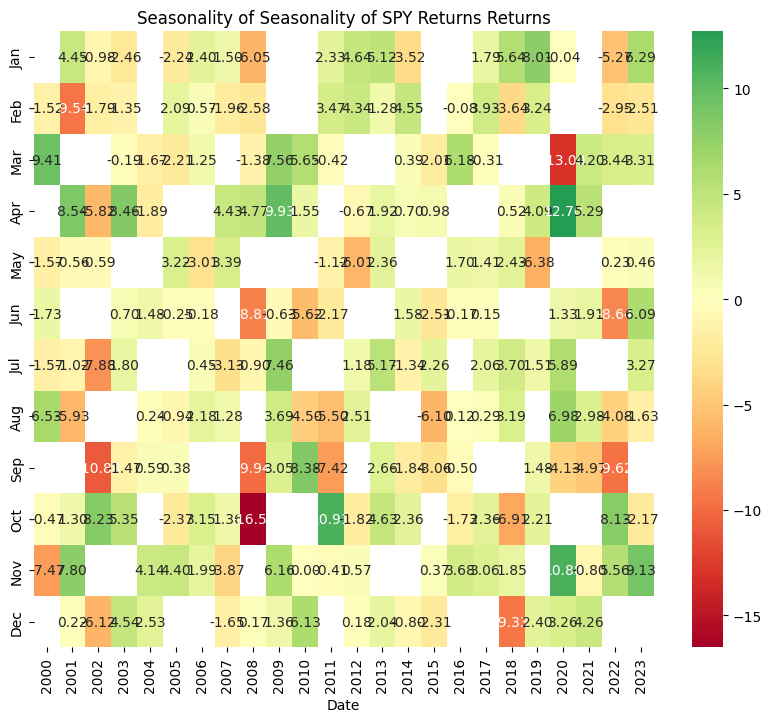

C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\3102572131.py:363: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return df.resample('M').agg({
[*********************100%%**********************]  1 of 1 completed
C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\2986058457.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\2986058457.py:328: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Volume'] = df['Volume'].resample(period).sum()  # Sum volume for each period
C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\2986058457.py:335: FutureWarning: The provided callable <function mean at 0x000001DD6D832FC0> is currently using DataFrameGroupBy.mean. In a future version o

Jan: Mean = 0.12, Std Dev = 4.41, Count = 23.0, Positive Prob = 0.46, Kelly Size = -19.42
Feb: Mean = -0.43, Std Dev = 4.40, Count = 24.0, Positive Prob = 0.50, Kelly Size = 5.66
Mar: Mean = 1.36, Std Dev = 4.65, Count = 24.0, Positive Prob = 0.71, Kelly Size = -0.29
Apr: Mean = 2.02, Std Dev = 4.87, Count = 24.0, Positive Prob = 0.75, Kelly Size = 0.15
May: Mean = 0.48, Std Dev = 3.53, Count = 24.0, Positive Prob = 0.67, Kelly Size = -1.77
Jun: Mean = -0.32, Std Dev = 3.97, Count = 24.0, Positive Prob = 0.58, Kelly Size = 5.74
Jul: Mean = 1.65, Std Dev = 3.90, Count = 24.0, Positive Prob = 0.67, Kelly Size = -0.12
Aug: Mean = 0.20, Std Dev = 3.69, Count = 24.0, Positive Prob = 0.62, Kelly Size = -6.16
Sep: Mean = -1.53, Std Dev = 5.03, Count = 24.0, Positive Prob = 0.50, Kelly Size = 2.14
Oct: Mean = 1.43, Std Dev = 5.78, Count = 24.0, Positive Prob = 0.62, Kelly Size = -0.90
Nov: Mean = 2.37, Std Dev = 4.45, Count = 24.0, Positive Prob = 0.75, Kelly Size = 0.28
Dec: Mean = 0.79, Std 

KeyError: 'mean'

In [64]:
def main():
    tickers = ['SPY', 'QQQ', 'TQQQ', 'SOXL', 'TSLL', 'NVDL']
    start_date = '2000-01-01'
    end_date = '2024-01-01'
    for ticker in tickers:
        analyze_ticker(ticker, start_date, end_date)
        # Create summary CSV
        create_summary_csv(tickers, start_date, end_date)



if __name__ == "__main__":
    main()

In [ ]:
def hedge():
    tickers = ['UVXY','SPXS','SQQQ', 'SOXS', 'TSLS', 'NVDS']
    start_date = '2000-01-01'
    end_date = '2024-01-01'
    for ticker in tickers:
        analyze_ticker(ticker, start_date, end_date)
        display_all_monthly_statistics(df, ticker)
        # Create summary CSV
        create_summary_csv(tickers, start_date, end_date)
if __name__ == "__main__":
    main()


In [100]:


# def display_all_monthly_statistics(df, ticker):
#     df = calculate_technical_indicators(df)
    
#     # Resample data to monthly
#     df_monthly = df.resample('M').agg({
#         'Open': 'first',
#         'High': 'max',
#         'Low': 'min',
#         'Close': 'last',
#         'Volume': 'sum',
#         'ATR': 'mean',
#         'RSI': 'mean',
#         '20 Day MA': 'mean',
#         'Upper Band': 'mean',
#         'Lower Band': 'mean',
#         'tenkan_sen': 'mean',
#         'kijun_sen': 'mean',
#         'senkou_span_a': 'mean',
#         'senkou_span_b': 'mean',
#         'chikou_span': 'mean'
#     })
    
#     df_monthly['Return'] = df_monthly['Close'].pct_change() * 100
    
#     months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
#     for month in range(1, 13):
#         monthly_data = df_monthly[df_monthly.index.month == month]
#         if monthly_data.empty:
#             continue
#         mean_return = monthly_data['Return'].mean()
#         std_return = monthly_data['Return'].std()
#         highest_return_year = monthly_data['Return'].idxmax().year
#         highest_return_value = monthly_data['Return'].max()
#         lowest_return_year = monthly_data['Return'].idxmin().year
#         lowest_return_value = monthly_data['Return'].min()
#         mean_volume = monthly_data['Volume'].mean()
#         highest_volume_year = monthly_data['Volume'].idxmax().year
#         highest_volume_value = monthly_data['Volume'].max()
#         lowest_volume_year = monthly_data['Volume'].idxmin().year
#         lowest_volume_value = monthly_data['Volume'].min()

#         print(f"{ticker} - {months[month-1]} Statistics")
#         print(f"Mean {months[month-1]} Return: {mean_return:.2f}%")
#         print(f"Standard Deviation of {months[month-1]} Returns: {std_return:.2f}%")
#         print(f"Highest {months[month-1]} Return: {highest_return_value:.2f}% in {highest_return_year}")
#         print(f"Lowest {months[month-1]} Return: {lowest_return_value:.2f}% in {lowest_return_year}")
#         print(f"Mean {months[month-1]} Volume: {mean_volume:.2f}")
#         print(f"Highest {months[month-1]} Volume: {highest_volume_value:.2f} in {highest_volume_year}")
#         print(f"Lowest {months[month-1]} Volume: {lowest_volume_value:.2f} in {lowest_volume_year}")
#         print(f"Mean {months[month-1]} ATR: {monthly_data['ATR'].mean():.2f}")
#         print(f"Mean {months[month-1]} RSI: {monthly_data['RSI'].mean():.2f}")
#         print(f"Mean {months[month-1]} 20 Day MA: {monthly_data['20 Day MA'].mean():.2f}")
#         print(f"Mean {months[month-1]} Upper Band: {monthly_data['Upper Band'].mean():.2f}")
#         print(f"Mean {months[month-1]} Lower Band: {monthly_data['Lower Band'].mean():.2f}")
#         print(f"Mean {months[month-1]} Tenkan-sen: {monthly_data['tenkan_sen'].mean():.2f}")
#         print(f"Mean {months[month-1]} Kijun-sen: {monthly_data['kijun_sen'].mean():.2f}")
#         print(f"Mean {months[month-1]} Senkou Span A: {monthly_data['senkou_span_a'].mean():.2f}")
#         print(f"Mean {months[month-1]} Senkou Span B: {monthly_data['senkou_span_b'].mean():.2f}")
#         print(f"Mean {months[month-1]} Chikou Span: {monthly_data['chikou_span'].mean():.2f}")

#         # Add checks for conditions
#         close_greater_than_rsi = (monthly_data['Close'] > monthly_data['RSI']).sum()
#         close_greater_than_upper_band = (monthly_data['Close'] > monthly_data['Upper Band']).sum()
#         high_greater_than_atr = (monthly_data['High'] > monthly_data['ATR']).sum()

#         print(f"Number of days Close > RSI in {months[month-1]}: {close_greater_than_rsi}")
#         print(f"Number of days Close > Upper Bollinger Band in {months[month-1]}: {close_greater_than_upper_band}")
#         print(f"Number of days High > ATR in {months[month-1]}: {high_greater_than_atr}")
#         print()


# import yfinance as yf
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from datetime import datetime
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Import custom functions
# from data_processing import (
#     resample_to_monthly, apply_kelly_method, load_price_data,
#     calculate_returns
# )

# plt.rcParams['figure.figsize'] = (8, 6)

def calculate_technical_indicators(df):
    # Calculate ATR
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['ATR'] = true_range.rolling(window=14).mean()
    
    # Calculate RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))
    
    # Calculate Bollinger Bands
    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    
    # Calculate Ichimoku Cloud
    high_9 = df['High'].rolling(window=9).max()
    low_9 = df['Low'].rolling(window=9).min()
    df['tenkan_sen'] = (high_9 + low_9) / 2

    high_26 = df['High'].rolling(window=26).max()
    low_26 = df['Low'].rolling(window=26).min()
    df['kijun_sen'] = (high_26 + low_26) / 2

    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)
    high_52 = df['High'].rolling(window=52).max()
    low_52 = df['Low'].rolling(window=52).min()
    df['senkou_span_b'] = ((high_52 + low_52) / 2).shift(26)

    df['chikou_span'] = df['Close'].shift(-26)
    
    return df

def display_all_monthly_statistics_with_kelly(ticker, start_date, end_date):
    """Display all monthly statistics for a DataFrame with Kelly position size."""
    print(f"[*******************************************] \n Analyzing {ticker} from {start_date} to {end_date} \n [*******************************************]\n")
    df = load_price_data(ticker, start=start_date, end=end_date)
    df = calculate_technical_indicators(df)
    df = calculate_returns(df)
    # print(f"Displaying all monthly statistics for {df} with Kelly position size...\n")
    df_monthly = resample_to_monthly(df)
    df_monthly['Monthly Return'] = df_monthly['Adj Close'].pct_change() * 100

    stats = df_monthly.groupby(df_monthly.index.month)['Monthly Return'].agg(['mean', 'std', 'count'])
    stats['positive_prob'] = df_monthly.groupby(df_monthly.index.month)['Monthly Return'].apply(lambda x: (x > 0).mean())
    stats['kelly_size'] = stats.apply(lambda row: apply_kelly_method(row['mean'], row['std'], row['positive_prob']), axis=1)
    
    stats['highest_return_value'] = df_monthly.groupby(df_monthly.index.month)['Monthly Return'].max()
    stats['highest_return_year'] = df_monthly.groupby(df_monthly.index.month)['Monthly Return'].idxmax().apply(lambda x: x.year)
    stats['lowest_return_value'] = df_monthly.groupby(df_monthly.index.month)['Monthly Return'].min()
    stats['lowest_return_year'] = df_monthly.groupby(df_monthly.index.month)['Monthly Return'].idxmin().apply(lambda x: x.year)
    stats['mean_volume'] = df_monthly.groupby(df_monthly.index.month)['Volume'].mean()
    stats['highest_volume_value'] = df_monthly.groupby(df_monthly.index.month)['Volume'].max()
    stats['highest_volume_year'] = df_monthly.groupby(df_monthly.index.month)['Volume'].idxmax().apply(lambda x: x.year)
    stats['lowest_volume_value'] = df_monthly.groupby(df_monthly.index.month)['Volume'].min()
    stats['lowest_volume_year'] = df_monthly.groupby(df_monthly.index.month)['Volume'].idxmin().apply(lambda x: x.year)

    stats.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    stats['Ticker'] = ticker

    return stats

def main():
    tickers = ['SPY', 'QQQ', 'SOXL', 'TSLA', 'NVDA']
    start_date = '2000-01-01'
    end_date = '2024-01-01'

    all_stats = []
    for ticker in tickers:
        stats = display_all_monthly_statistics_with_kelly(ticker, start_date, end_date)
        print(stats)
        all_stats.append(stats)
    
    all_stats_df = pd.concat(all_stats)
    all_stats_df.to_csv('all_tickers_monthly_statistics.csv')
    print("CSV file created: all_tickers_monthly_statistics.csv")

if __name__ == "__main__":
    main()


[*********************100%%**********************]  1 of 1 completed

[*******************************************] 
 Analyzing SPY from 2000-01-01 to 2024-01-01 
 [*******************************************]

         mean       std  count  positive_prob  kelly_size  \
Jan  0.120099  4.406626     23       0.458333  -19.416338   
Feb -0.426746  4.401933     24       0.500000    5.657561   
Mar  1.355570  4.649287     24       0.708333   -0.292015   
Apr  2.019983  4.871534     24       0.750000    0.147082   
May  0.483276  3.525543     24       0.666667   -1.765029   
Jun -0.320340  3.966717     24       0.583333    5.742840   
Jul  1.651707  3.902369     24       0.666667   -0.120876   
Aug  0.203991  3.691356     24       0.625000   -6.160890   
Sep -1.532038  5.029787     24       0.500000    2.141535   
Oct  1.425641  5.781812     24       0.625000   -0.895846   
Nov  2.373915  4.446478     24       0.750000    0.281736   
Dec  0.793515  3.591289     24       0.666667   -0.841932   

     highest_return_value  highest_return_year  lowest_return_val


C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\3102572131.py:363: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return df.resample('M').agg({
[*********************100%%**********************]  1 of 1 completed
C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\3102572131.py:363: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return df.resample('M').agg({
[*********************100%%**********************]  1 of 1 completed
C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\3102572131.py:363: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return df.resample('M').agg({
[*********************100%%**********************]  1 of 1 completed

         mean       std  count  positive_prob  kelly_size  \
Jan  0.924944  6.254758     23       0.583333   -2.234297   
Feb -0.495506  8.083708     24       0.416667    9.933196   
Mar  1.284093  5.893102     24       0.666667   -0.863104   
Apr  1.735155  7.966030     24       0.625000   -1.096610   
May  0.790040  6.065332     24       0.583333   -2.615519   
Jun  0.151300  5.880455     24       0.541667  -17.272003   
Jul  2.261617  5.601012     24       0.750000    0.130862   
Aug  0.819333  5.712429     24       0.541667   -2.653854   
Sep -2.368662  7.738038     24       0.416667    2.322323   
Oct  2.872041  7.968565     24       0.625000   -0.415449   
Nov  2.256163  8.078777     24       0.750000   -0.145190   
Dec -0.376842  4.783419     24       0.500000    6.846725   

     highest_return_value  highest_return_year  lowest_return_value  \
Jan             10.642940                 2023           -11.889847   
Feb             19.024394                 2000           -26.205


C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\3102572131.py:363: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return df.resample('M').agg({
[*********************100%%**********************]  1 of 1 completed

          mean        std  count  positive_prob  kelly_size  \
Jan   8.923711  21.736985     13       0.615385   -0.321488   
Feb   3.218659  12.974625     13       0.461538   -1.709035   
Mar   0.959116  15.650027     13       0.538462   -6.992527   
Apr   6.091480  21.622425     13       0.538462   -1.099823   
May   5.544112  25.936139     13       0.461538   -2.057461   
Jun  10.193366  12.434371     13       0.714286    0.365757   
Jul   3.469624  16.433305     14       0.500000   -1.868168   
Aug   6.791826  22.390692     14       0.500000   -1.148356   
Sep  -1.323981   7.788342     14       0.357143    4.138762   
Oct   2.965162  20.072530     14       0.357143   -3.994650   
Nov   9.803377  22.183515     14       0.714286    0.067759   
Dec  -0.362820  17.799544     14       0.571429   21.596663   

     highest_return_value  highest_return_year  lowest_return_value  \
Jan             55.515986                 2020           -20.336656   
Feb             34.948466             


C:\Users\Administrator\AppData\Local\Temp\ipykernel_41436\3102572131.py:363: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return df.resample('M').agg({
